<a href="https://colab.research.google.com/github/rubyvanrooyen/ARIWS-Cookbook/blob/main/utils/MeerKAT_Array_Layout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and installation

Install mpl-toolkits.basemap dependencies

In [1]:
!apt install python3-matplotlib python3-pyproj python3-pyshp python-mpltoolkits.basemap-data libgeos-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-lyx javascript-common libjs-jquery libjs-jquery-ui
  python-matplotlib-data python3-cycler python3-dateutil python3-olefile
  python3-pil python3-pyparsing python3-six python3-tz ttf-bitstream-vera
Suggested packages:
  apache2 | lighttpd | httpd libgdal-doc libjs-jquery-ui-docs
  python-cycler-doc dvipng gir1.2-gtk-3.0 ghostscript inkscape ipython3
  python-matplotlib-doc python3-cairocffi python3-gi-cairo python3-gobject
  python3-nose python3-pyqt4 python3-scipy python3-sip python3-tornado
  texlive-extra-utils texlive-latex-extra ttf-staypuft python-pil-doc
  python3-pil-dbg python-pyparsing-doc
The following NEW packages will be installed:
  fonts-lyx javascript-common libgeos-dev libjs-jquery libjs-jquery-ui
  python-matplotlib-data python-mpltoolkits.basemap-data python3-cycler
  python3-dateutil python3-matplotlib python3-o

Install basemap version 1.2.0 (bug fix version of default version 1.1.0)

You will be asked to restart runtime, restart before continuing to next cell

In [2]:
!pip install https://github.com/matplotlib/basemap/archive/v1.2.0rel.zip

     \ 148.5MB 477kB/s
  Created wheel for basemap: filename=basemap-1.2.0-cp36-cp36m-linux_x86_64.whl size=121645983 sha256=6a41f765b9a6ad01601d5f5721651d2e1a27b9eb6f759e7f1623237092bd6335
  Stored in directory: /tmp/pip-ephem-wheel-cache-wsudf075/wheels/3c/ad/51/cf7c93cb1cbf1d8ecec0acc46ddec72e1089ea9edb6a59b500
Successfully built basemap


Run after restarting runtime to check installation success

In [1]:
from mpl_toolkits.basemap import Basemap

# Import libraries

In [2]:
import astropy.constants as phys
import ephem
import matplotlib.pyplot as plt
import numpy as np
import yaml

from astropy import units as u
from astropy.coordinates import Longitude, Latitude, EarthLocation
from astropy.coordinates import ICRS, SkyCoord
from datetime import datetime, timedelta
from numpy import recarray

from ipywidgets import widgets
from IPython.display import display

# Read MeerKAT config file with antenna positions

In [3]:
class MKAT(object):
    def __init__(self, mkat_config):
        self.ref_position = None
        arr_desc = {'names': ('name', 'east', 'north', 'up', 'location'),
                    'formats': ('S5', float, float, float, EarthLocation)}
        self.antennas = recarray((0,), dtype=arr_desc)
        self.build_array(mkat_config)
        
        self.frequency = 1420e6 / u.s
        self.wavelength = phys.c / self.frequency
        self.nr_antennas = len(self.antennas)
        self.nr_baselines = (self.nr_antennas * (self.nr_antennas - 1)) // 2
        
        self.observer = self.ephem_observer()
        
    def build_array(self, filename):
        """Read array default .yaml file."""
        with open(filename, "r") as stream:
            data = yaml.safe_load(stream)
        self.get_reference(data['reference'])
        self.get_antennas(data['antennas'])
 
    def get_reference(self, ref_position):
        """General Earth position for the Telescope"""
        self.ref_LAT = Latitude(ref_position['latitude'],
                                u.degree,
                                copy=False)
        self.ref_LON = Longitude(ref_position['longitude'],
                                 u.degree,
                                 wrap_angle=180. * u.degree,
                                 copy=False)
        self.ref_ALT = u.Quantity(ref_position['altitude'],
                                  u.m,
                                  copy=False)
        self.ref_position = EarthLocation(lat=self.ref_LAT,
                                          lon=self.ref_LON,
                                          height=self.ref_ALT)
 
    def get_antennas(self, antennas):
        """ENU coordinates per antenna"""
        if self.ref_position is not None:
            [ref_x, ref_y, ref_z] = self.ref_position.to_geocentric()

        self.antennas.resize(len(antennas))
        for cnt, antenna in enumerate(antennas):
            ant_ = [item.strip() for item in antenna.split(",")]
            for item_ in ant_:
                for prefix_ in ('name', 'east', 'north', 'up'):
                    val_ =  None
                    if item_.startswith(prefix_):
                        val_ =  item_.split('=')[-1].strip()
                    if val_ is not None:
                        self.antennas[cnt][prefix_] = val_
            if self.ref_position is not None:
                L_sin = np.sin(self.ref_LAT.rad)
                L_cos = np.cos(self.ref_LAT.rad)
                x = -L_sin * self.antennas[cnt]['north'] + \
                    L_cos * self.antennas[cnt]['up']
                y = self.antennas[cnt]['east']
                z = L_cos * self.antennas[cnt]['north'] + \
                    L_sin * self.antennas[cnt]['up']
                # MeerKAT antenna positions, ITRF, m
                self.antennas[cnt]['location'] = EarthLocation(x=(ref_x.value+x)*u.m,
                                                               y=(ref_y.value+y)*u.m,
                                                               z=(ref_z.value+z)*u.m)

    def ephem_observer(self):
        lon = self.ref_position.geodetic[0].degree
        lat = self.ref_position.geodetic[1].degree
        alt = self.ref_position.geodetic[2].value
        observer = ephem.Observer()
        observer.lon = str(lon)
        observer.lat = str(lat)
        observer.elevation = alt
        return observer
    
    def baselines(self):
        """The function evaluates baselines lenghts
           and the angle between antennas
        """
        P = np.array([self.antennas['north'],
                      self.antennas['east']]).T
        # antenna position in wavelength units
        P = P / self.wavelength.value  # baseline

        bl_length = np.zeros((self.nr_baselines, ))
        bl_az_angle = np.zeros((self.nr_baselines, ))
        cnt = 0
        for idx0 in range(self.nr_antennas):
            for idx1 in range(idx0 + 1, self.nr_antennas):
                bl_len_p0 = (P[idx0, 0] - P[idx1, 0])**2
                bl_len_p1 = (P[idx0, 1] - P[idx1, 1])**2
                bl_length[cnt] = np.sqrt(bl_len_p0 + bl_len_p1)
                bl_az_angle[cnt] = np.arctan2((P[idx0, 1] - P[idx1, 1]),
                                              (P[idx0, 0] - P[idx1, 0]))
                cnt += 1

        return bl_length, bl_az_angle

In [4]:
#upload mkat_antennas.yml
from google.colab import files
uploaded = files.upload()

Saving mkat_antennas.yml to mkat_antennas.yml


In [5]:
mkat = MKAT('/content/mkat_antennas.yml')
def decode(text_):
    if isinstance(text_, str):
        text = text_
    else:
        text = text_.decode("utf-8")
    return text

# Get array
arr_latitude = []
arr_longitude = []
arr_names = []
for antenna in mkat.antennas:
    arr_names.append(decode(antenna['name']))
    arr_latitude.append(antenna['location'].lat.value)
    arr_longitude.append(antenna['location'].lon.value)

# Select antennas for array

In [6]:
class antennas():
    def __init__(self):
        
        self.antennas = {}
        self.construct_array()
        
        # build widget grid
        for ant_name in self.antennas.keys():
            self.antennas[ant_name] = self.ant_checkbox(ant_name)
        
    def construct_array(self):
        for cntr in range(0, 64):
            ant_name = 'm{:03d}'.format(cntr)
            self.antennas[ant_name] = None        
        
    def ant_checkbox(self, ant_name):
        return widgets.Checkbox(value=True,
                                description=ant_name,
                                disabled=False,
                                indent=False) 

In [7]:
def select_antennas(ant_array):
    array_ = np.empty([4, 16], dtype=widgets.Checkbox)
    for cnt, ant in enumerate(ant_array.antennas.keys()):
        array_[cnt//16, cnt%16] = ant_array.antennas[ant]
    antennas_ = widgets.VBox([widgets.HBox(array_[0,:].tolist()),
                              widgets.HBox(array_[1,:].tolist()),
                              widgets.HBox(array_[2,:].tolist()),
                              widgets.HBox(array_[3,:].tolist())])
    display(antennas_)
ant_array = antennas()
select_antennas(ant_array)

# MeerKAT array layout

Select the appropriate antennas from those listed above and and run the cells below to show array layout

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


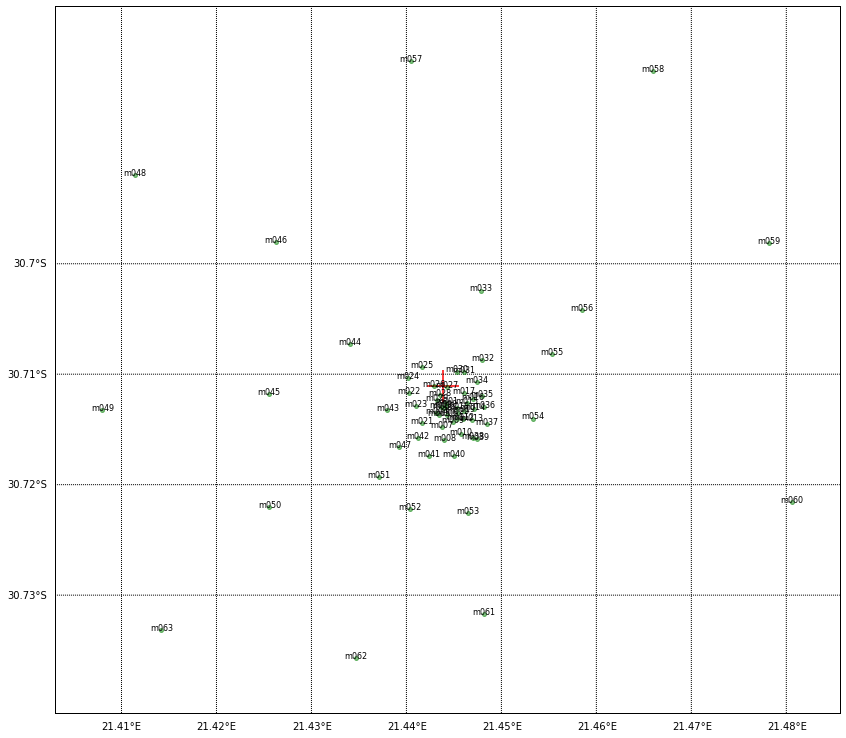

In [8]:
subarray = np.empty(np.shape(arr_names), dtype=bool)
for cnt, ant in enumerate(ant_array.antennas.keys()):
    subarray[cnt] = ant_array.antennas[ant].value

# Earth projection
m = Basemap(projection='merc',
            lat_0=mkat.ref_position.lat.value,
            lon_0=mkat.ref_position.lon.value,
            llcrnrlon=np.min(arr_longitude)-0.005,
            llcrnrlat=np.min(arr_latitude)-0.005,
            urcrnrlon=np.max(arr_longitude)+0.005,
            urcrnrlat=np.max(arr_latitude)+0.005)
# set regular grid and map projected coordinates
ref_x, ref_y = m(mkat.ref_position.lon.value, mkat.ref_position.lat.value)
arr_x, arr_y = m(arr_longitude, arr_latitude)
subarr_x, subarr_y = m(np.array(arr_longitude)[subarray], np.array(arr_latitude)[subarray])

# Array layout
plt.figure(figsize=(20, 13), facecolor='white');
# draw parallels.
parallels = np.arange(-30.73, -30.69, .01)
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10);
# draw meridians
meridians = np.arange(21.41, 21.48, .01)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10);
m.drawmapboundary(fill_color='white');  # noqa
m.scatter(ref_x, ref_y, 1000, marker='+', color='r', label='Array reference');
m.plot(subarr_x, subarr_y, '.', markersize=8, color='g', alpha=0.5);
cntr = 0
for x, y in zip(arr_x, arr_y):
    plt.text(x, y, arr_names[cntr], fontsize=8, ha='center', va='baseline', color='k');
    cntr += 1